# Evaluation

In [ ]:
import sys
import os
import importlib

# set your working dir
work_dir = 'E:/IBL neural analysis/Github/remote/IBL_foundation_model'
os.chdir(work_dir)
print('working dir: ', work_dir)

path = 'src'
sys.path.append(str(path))

from src.utils.eval_utils import load_model_data_local, co_smoothing_r2, compare_R2_scatter, co_smoothing_bps, behavior_decoding

### 1.Configuration & Load
- The dataset will be split by `datasets.train_test_split(test_size=test_size, seed=seed)`

In [2]:
# Configuration
configs = {
    'model_config': 'src/configs/ndt1.yaml',
    'model_path': 'checkpoints/models/ndt1/ndt1_671c_unaligned_shuffle/model_best.pt',
    'trainer_config': 'src/configs/trainer.yaml',
    'dataset_path': 'data/671c7ea7-6726-4fbe-adeb-f89c2c8e489b_aligned', 
    'test_size': 0.15,
    'seed': 42,
    'freeze_encoder': False
}  

In [3]:
# load your model and dataloader
model, accelerator, dataset, dataloader = load_model_data_local(**configs)

seed set to 42
bin size: 0.02
len(dataset): 121
spike data shape: torch.Size([121, 100, 668])


### 2.Co-smoothing (From N-1 to 1) 
- using `co_smoothing_r2` for r2 and psth/residual plots.
- using `co_smoothing_bps` for co-bps stat.

In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': 'test', # used for file name of figures
    'save_path': 'figs/test',
    'mode': 'per_neuron',
    'n_time_steps': 100,    
    'is_aligned': True
}

co_smoothing_r2(model, accelerator, dataloader, dataset, **co_smoothing_configs)

neuron:   0%|                                                                                  | 0/668 [00:00<?, ?it/s]E:\IBL neural analysis\Github\remote\IBL_foundation_model\src\models\ndt1.py:332: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  out = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask, dropout_p=(self.attn_dropout if self.training else 0.0), is_causal=False) # (B,n_heads,T,head_size)
neuron:   1%|█                                                                        | 10/668 [00:13<12:45,  1.16s/it]E:\IBL neural analysis\Github\remote\IBL_foundation_model\src\utils\eval_utils.py:408: RuntimeWarning: divide by zero encountered in scalar divide
  return (nll_null - nll_model) / np.nansum(spikes) / np.log(2)
neuron: 100%|████████████████████████████████████████████████████████████████████████| 668/668 [12:52<00:00,  1.16s/it]


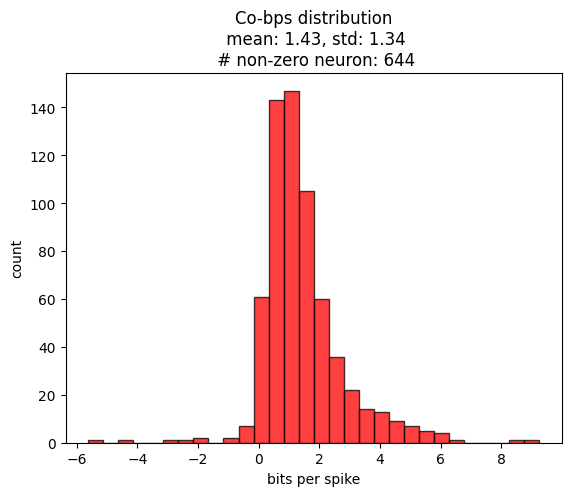

In [4]:
co_smoothing_bps(
    model, 
    accelerator, 
    dataloader, 
    dataset,
    mode='per_neuron'    # manual / active / region / per_neuron / forward-pred / etc (TODO)
)
# 1.938e-6,  0.00016529

### 3. Forward Prediction
- using `co_smoothing_r2` with mode `forward-pred` for r2 and psth/residual plots.
- using `co_smoothing_bps` with mode `forward-pred` for co-bps stat.

In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [],
    'method_name': 'test', # used for file name of figures
    'save_path': 'figs/test',
    'mode': 'forward_pred',
    'n_time_steps': 100,    
    'held_out_list': list(range(80, 100)),
    'is_aligned': True
}

co_smoothing_r2(model, accelerator, dataloader, dataset, **co_smoothing_configs)

In [ ]:
co_smoothing_bps(
    model, 
    accelerator, 
    dataloader, 
    dataset,
    mode = 'forward_pred',    # manual / active / region / per_neuron / forward-pred / etc (TODO)
    held_out_list = list(range(80, 100))
)

### 4. Inter-Region Prediction
- using `co_smoothing_r2` with mode `inter_region` for r2 and psth/residual plots.
- using `co_smoothing_bps` with mode `inter_region` for co-bps stat.

In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': 'test', # used for file name of figures
    'save_path': 'figs/test',
    'mode': 'inter_region',
    'n_time_steps': 100,    
    'held_out_list': None,
    'is_aligned': True,
    'target_regions': ['MARN']
}

co_smoothing_r2(model, accelerator, dataloader, dataset, **co_smoothing_configs)

In [ ]:
co_smoothing_bps(
    model, 
    accelerator, 
    dataloader, 
    dataset,
    mode = 'inter_region',    
    held_out_list = None,
    target_regions = ['MARN']
)

### 5. Intra-Region Prediction
- using `co_smoothing_r2` with mode `intra_region` for r2 and psth/residual plots.
- using `co_smoothing_bps` with mode `intra_region` for co-bps stat.

In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': 'test', # used for file name of figures
    'save_path': 'figs/test',
    'mode': 'intra_region',
    'n_time_steps': 100,    
    'held_out_list': [1,3,5,7,9],
    'is_aligned': True,
    'target_regions': ['MARN']
}

co_smoothing_r2(model, accelerator, dataloader, dataset, **co_smoothing_configs)

In [ ]:
co_smoothing_bps(
    model, 
    accelerator, 
    dataloader, 
    dataset,
    mode = 'intra_region',    
    held_out_list = [1,3,5,7,9],
    target_regions = ['MARN']
)

### 6. R2 Scatter Plot
- First, run 1 & 2 for each model you want to compare. A `r2.npy` file would be generated in the corresponding figs directory. (the same directory as the `save_path` in 2.)

In [ ]:
compare_r2_configs = {
    'A_path': 'figs/671c_ndt1_nm30_ualg_shuffle_best', # should be the same as the 'save_path' from above
    'B_path': 'figs/671c_ndt1_nm30_alg(-0.4)_shuffle_last',
    'A_name': 'unaligned',    # names for plots
    'B_name': 'aligned'
}    

compare_R2_scatter(**compare_r2_configs)

### 7. Behavior Decoding

In [2]:
# Configuration
configs = {
    'model_config': 'src/configs/ndt1.yaml',
    'model_path': 'checkpoints/models/ndt1/ndt1_671c_unaligned_shuffle/model_best.pt',
    'trainer_config': 'src/configs/trainer.yaml',
    'dataset_path': 'data/671c7ea7-6726-4fbe-adeb-f89c2c8e489b_aligned', 
    'save_path': 'figs/test',
    'test_size': 0.15,
    'seed': 42,
    'target': 'choice',
    'decoder': 'clf',
    'output_size': 2,
    'metric': 'acc'
}  

In [ ]:
# load your model and dataloader
results = behavior_decoding(**configs)

### 8. TODO